In [1]:
from Bio import SeqIO
import pandas as pd
import numpy as np

from genominterv.remapping import remap
from genominterv.remapping import interval_distance, genomic
from genominterv.remapping import remap_interval_data
import seaborn as sns

Load file fasta fiel

In [2]:
import pyBigWig
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm  # optional, for progress bar

file_path = "/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/data/macaca/gc5Base_chr8.txt"
import pandas as pd

# Load the file — tab-delimited
df_gc = pd.read_csv(file_path, sep="\t", header=None)

# Name the columns (standard BedGraph format)
df_gc.columns = ["chrom", "start", "end", "value"]

# Show the first few rows
df_gc.head()



,chrom,start,end,value
0,chr8,0,5,20.0
1,chr8,5,15,80.0
2,chr8,15,20,20.0
3,chr8,20,25,60.0
4,chr8,25,30,40.0


## loading eigenvectors using kasper code

In [3]:
import pandas as pd
import numpy as np
import re
from pathlib import Path

def parse_compartment_data(file_name, bin_size=100_000, chrom_default=None):
    p = Path(file_name)
    df = pd.read_csv(p, sep="\t", comment="#", low_memory=False)

    # harmonize column names
    df.columns = [c.strip() for c in df.columns]

    # find eigenvector column
    if "e1" not in df.columns:
        for cand in ["value", "PC1", "pc1", "eig1", "Eig1", "E1"]:
            if cand in df.columns:
                df = df.rename(columns={cand: "e1"})
                break
        else:
            raise KeyError(f"No eigenvector column found; expected one of e1/value/PC1/eig1. Got: {list(df.columns)}")

    # numeric & drop NA
    df["e1"] = pd.to_numeric(df["e1"], errors="coerce")
    df = df.dropna(subset=["e1"]).reset_index(drop=True)

    # start/end
    if not {"start", "end"}.issubset(df.columns):
        df["start"] = np.arange(len(df)) * bin_size
        df["end"] = df["start"] + bin_size

    # chrom
    if "chrom" not in df.columns:
        m = re.search(r"(chr[0-9XYM]+)", str(p))
        df["chrom"] = m.group(1) if m else (chrom_default or "chr8")

    # sign & segments
    df["sign"] = np.sign(df["e1"])
    # mark segment starts where sign changes
    seg_start = df["sign"].shift(fill_value=df["sign"].iloc[0]) != df["sign"]
    df["segment_id"] = seg_start.cumsum()

    comp = (
        df.groupby("segment_id", as_index=False)
          .agg(e1_mean=("e1", "mean"),
               start=("start", "min"),
               end=("end", "max"),
               sign=("sign", "mean"),
               chrom=("chrom", "first"))
    )
    comp["comp"] = np.where(comp["e1_mean"] >= 0, "A", "B")  # use >= if zero should be A
    compartments = comp[["comp", "start", "end", "chrom"]].astype({"start": int, "end": int}).reset_index(drop=True)

    # edges = starts where sign changed
    compartment_edges = df.loc[seg_start, "start"].to_numpy()

    return compartments, compartment_edges

def edge_segments(compartment_edges, flank_bp=1, chrom="chr8"):
    edges = np.asarray(compartment_edges, dtype=int)
    return pd.DataFrame({"start": edges, "end": edges + flank_bp, "chrom": chrom})


In [4]:
import os

# Load data
eigentrack_dir = "/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/data/eigentrack_chr8"
eigentrack_files = [
    f for f in os.listdir(eigentrack_dir) if f.endswith("_100kb.tsv")
]

comps_dict = {}
edges_dict = {}
generated_comps=[]
generated_edges=[]
a_and_b_comps = []

for filename in eigentrack_files:
    filepath = os.path.join(eigentrack_dir, filename)
    base = os.path.splitext(filename)[0]
    comps_var = f"{base}_comps"
    edges_var = f"{base}_edges"
    comps, edges = parse_compartment_data(filepath)
    comps_dict[comps_var] = comps
    edges_dict[edges_var] = edges
    generated_comps.append(comps_var)
    generated_edges.append(edges_var)

print("Generated variable names:", generated_comps)
print("Generated variable names:", generated_edges)

for edge_var in generated_edges:
    # Get the numpy array of edges from the dictionary
    edges = edges_dict[edge_var]
    
    # Create the DataFrame using edge_segments with flank=1
    seg_name = f"{edge_var}_interval"
    seg_df = edge_segments(edges, 1)
    #print(f"Created: {seg_name}")

    # Merge compartment assignment
    comps_var = edge_var.replace("_edges", "_comps")
    if comps_var in comps_dict:
        comps_df = comps_dict[comps_var]
        
        comp_df = pd.DataFrame({
            'comp': comps_df['comp'].reset_index(drop=True),
            'start': seg_df['start'].reset_index(drop=True),
            'end': seg_df['end'].reset_index(drop=True),
            'chrom': seg_df['chrom'].reset_index(drop=True)
        })

        # Save full merged comp_df
        comp_full_name = f"{edge_var}_interval_comp"
            # Save combined A and B compartments
        comp_AB_name = f"{edge_var}_AB"
        globals()[comp_AB_name] = comp_df
        a_and_b_comps.append(comp_AB_name)

        #print(f"Created: {comp_full_name}")

        # Split into compartments A and B
        comp_A = comp_df[comp_df['comp'] == 'A'].reset_index(drop=True)
        comp_B = comp_df[comp_df['comp'] == 'B'].reset_index(drop=True)

        # Save A and B splits as new variables
        comp_A_name = f"{edge_var}_A"
        comp_B_name = f"{edge_var}_B"
        globals()[comp_A_name] = comp_A
        globals()[comp_B_name] = comp_B
        a_and_b_comps.append(comp_A_name)
        a_and_b_comps.append(comp_B_name)
        
        #print(f"Created: {edge_var}_A and {edge_var}_B")

print("Generated compartment A and B variables:", a_and_b_comps)

#print(sperm_e1_100kb_10Mb_edges_A.head())

print(globals()[comp_AB_name].head(30))
print(globals()[comp_AB_name].shape)

Generated variable names: ['fibroblast_e1_100kb_comps', 'pachytene_spermatocyte_e1_100kb_comps', 'round_spermatid_e1_100kb_comps', 'spermatogonia_e1_100kb_comps', 'sperm_e1_100kb_comps']
Generated variable names: ['fibroblast_e1_100kb_edges', 'pachytene_spermatocyte_e1_100kb_edges', 'round_spermatid_e1_100kb_edges', 'spermatogonia_e1_100kb_edges', 'sperm_e1_100kb_edges']
Generated compartment A and B variables: ['fibroblast_e1_100kb_edges_AB', 'fibroblast_e1_100kb_edges_A', 'fibroblast_e1_100kb_edges_B', 'pachytene_spermatocyte_e1_100kb_edges_AB', 'pachytene_spermatocyte_e1_100kb_edges_A', 'pachytene_spermatocyte_e1_100kb_edges_B', 'round_spermatid_e1_100kb_edges_AB', 'round_spermatid_e1_100kb_edges_A', 'round_spermatid_e1_100kb_edges_B', 'spermatogonia_e1_100kb_edges_AB', 'spermatogonia_e1_100kb_edges_A', 'spermatogonia_e1_100kb_edges_B', 'sperm_e1_100kb_edges_AB', 'sperm_e1_100kb_edges_A', 'sperm_e1_100kb_edges_B']
   comp       start         end chrom
0     A   1300000.0   1300001.0

## not nesesary

In [5]:
for edge_var in generated_edges:
    comp_AB_name = f"{edge_var}_AB"
    if comp_AB_name in globals():
        print(f"Head of {comp_AB_name}:")
        print(globals()[comp_AB_name].head())
        print()

Head of fibroblast_e1_100kb_edges_AB:
  comp      start        end chrom
0    A   800000.0   800001.0  chr8
1    B  2300000.0  2300001.0  chr8
2    A  2500000.0  2500001.0  chr8
3    B  7200000.0  7200001.0  chr8
4    A  7400000.0  7400001.0  chr8

Head of pachytene_spermatocyte_e1_100kb_edges_AB:
  comp      start        end chrom
0    B  2200000.0  2200001.0  chr8
1    A  2500000.0  2500001.0  chr8
2    B  7100000.0  7100001.0  chr8
3    A  7600000.0  7600001.0  chr8
4    B  8600000.0  8600001.0  chr8

Head of round_spermatid_e1_100kb_edges_AB:
  comp      start        end chrom
0    A  1400000.0  1400001.0  chr8
1    B  2200000.0  2200001.0  chr8
2    A  2600000.0  2600001.0  chr8
3    B  7100000.0  7100001.0  chr8
4    A  7700000.0  7700001.0  chr8

Head of spermatogonia_e1_100kb_edges_AB:
  comp       start         end chrom
0    B  18900000.0  18900001.0  chr8
1    A  19100000.0  19100001.0  chr8
2    B  19300000.0  19300001.0  chr8
3    A  19600000.0  19600001.0  chr8
4    B  19

# GC Content Remapping Script

This script remaps GC content data to genomic edge data for multiple samples and saves the results to text files.

## Steps

1. **Define Input DataFrames**
   A dictionary `df_for_remapping` maps sample names to their corresponding edge DataFrames. These DataFrames contain genomic interval data for compartments A and B.

2. **Clean GC Reference File**
   The GC content DataFrame `df_gc` is cleaned:
   - Rows with missing `start` or `end` values are dropped.
   - Coordinates are cast to integers.
   - Sorted by chromosome and genomic position.

3. **Iterate Over Samples**
   For each sample:
   - The edge DataFrame is cleaned similarly (drop missing values, cast to `int`, sort).
   - GC content is remapped to the edge intervals using the `remap_interval_data` function, with proximal coordinate inclusion.
   - Additional columns (`mid`, `absmid`) are computed to represent the interval midpoint and its absolute value.
   - Rows with missing key values are dropped to ensure a clean result.

4. **Save Output**
   The remapped and post-processed result is saved as a tab-separated `.txt` file in the `remapping/` directory, named according to the sample.

5. **Progress Logging**
   A message is printed for each sample once processing is complete.


In [6]:
# # Define all input edge DataFrames by name
# df_for_remapping = {
#     "sperm_e1_100kb_10Mb_edges_AB": sperm_e1_100kb_edges_AB,
#     "round_spermatid_e1_100kb_10Mb_edges_AB": round_spermatid_e1_100kb_edges_AB,
#     "pachytene_spermatocyte_e1_100kb_10Mb_edges_AB": pachytene_spermatocyte_e1_100kb_edges_AB,
#     "spermatogonia_e1_100kb_10Mb_edges_AB": spermatogonia_e1_100kb_edges_AB,
#     "fibroblast_e1_100kb_10Mb_edges_AB": fibroblast_e1_100kb_edges_AB
# }

# # Clean the GC reference file once
# df_gc = df_gc.dropna(subset=["start", "end"]).copy()
# df_gc["start"] = df_gc["start"].astype(int)
# df_gc["end"] = df_gc["end"].astype(int)
# df_gc = df_gc.sort_values(by=["chrom", "start", "end"])


# for name, df in df_for_remapping.items():
#     print(f"Processing {name}")
#             # Clean and sort
#     df_clean = df.dropna(subset=["start", "end"]).copy()
#     df_clean["start"] = df_clean["start"].astype(int)
#     df_clean["end"] = df_clean["end"].astype(int)

#     #print(df_clean.head())

#     result = remap_interval_data(df_gc, df_clean, include_prox_coord=True)
#     # Post-process
#     result["mid"] = (result["start"] + result["end"]) / 2
#     result["absmid"] = result["mid"].abs()

#     # Map comp from start_prox using df_clean
#     start_to_comp = df_clean.drop_duplicates(subset=["start"]).set_index("start")["comp"]
#     result["comp"] = result["start_prox"].map(start_to_comp)

#     result = result.dropna(subset=["start", "end", "mid", "absmid", "start_prox", "end_prox"], how="any")
#     result.to_csv(f"/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/data/macaca/remapping/chr8/{name}_gc_remap_drop_na.txt", sep="\t", index=False)
#     print(f"{name} done")

# print("finaly done ")

In [7]:
## drop na
import pandas as pd

# Load the file into a DataFrame
file_path1 = "/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/data/macaca/remapping/chr8/fibroblast_e1_100kb_10Mb_edges_AB_gc_remap_drop_na.txt"
fibroblast = pd.read_csv(file_path1, sep="\t")
print("fibroblast:", fibroblast.shape)

file_path2 = "/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/data/macaca/remapping/chr8/sperm_e1_100kb_10Mb_edges_AB_gc_remap_drop_na.txt"
sperm = pd.read_csv(file_path2, sep="\t")
print("sperm:", sperm.shape)

file_path3 = "/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/data/macaca/remapping/chr8/round_spermatid_e1_100kb_10Mb_edges_AB_gc_remap_drop_na.txt"
round_spermatid = pd.read_csv(file_path3, sep="\t")
print("round_spermatid:", round_spermatid.shape)

file_path4 = "/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/data/macaca/remapping/chr8/pachytene_spermatocyte_e1_100kb_10Mb_edges_AB_gc_remap_drop_na.txt"
pachytene_spermatocyte = pd.read_csv(file_path4, sep="\t")
print("pachytene_spermatocyte:", pachytene_spermatocyte.shape)

file_path5 = "/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/data/macaca/remapping/chr8/spermatogonia_e1_100kb_10Mb_edges_AB_gc_remap_drop_na.txt"
spermatogonia = pd.read_csv(file_path5, sep="\t")
print("spermatogonia:", spermatogonia.shape)

# Display the first few rows
print(fibroblast.head())


fibroblast: (20645126, 11)
sperm: (20559311, 11)
round_spermatid: (19758171, 11)
pachytene_spermatocyte: (19585964, 11)
spermatogonia: (17142499, 11)
   start   end  start_prox  end_prox chrom  start_orig  end_orig  value   mid  \
0    9.0  14.0    800000.0  800001.0  chr8      800010    800015   60.0  11.5   
1   14.0  19.0    800000.0  800001.0  chr8      800015    800020   40.0  16.5   
2   19.0  24.0    800000.0  800001.0  chr8      800020    800025   60.0  21.5   
3   24.0  29.0    800000.0  800001.0  chr8      800025    800030   20.0  26.5   
4   29.0  34.0    800000.0  800001.0  chr8      800030    800035   40.0  31.5   

   absmid comp  
0    11.5    A  
1    16.5    A  
2    21.5    A  
3    26.5    A  
4    31.5    A  


In [8]:
### making the function


'''Step 1
def filter into in A and B compartment:

#seperate into A and B
    A_val = result[
        ((result['comp'] == 'A') & (result['start'] < 0)) |
        ((result['comp'] == 'B') & (result['start'] > 0))
    ].copy()
    B_val = result[
        ((result['comp'] == 'A') & (result['start'] > 0)) |
        ((result['comp'] == 'B') & (result['start'] < 0))
return avarges_A, avarges_B

'''
def filter_into_A_B_compartments(result):
    """
    Splits the input DataFrame into A and B compartments based on sign of 'start' and compartment identity.
    
    Parameters:
        result (pd.DataFrame): Must include columns 'comp' and 'start'.
    
    Returns:
        A_val (pd.DataFrame): Entries where position is consistent with Compartment A.
        B_val (pd.DataFrame): Entries where position is consistent with Compartment B.
    """
    # Entries within A compartment (left of origin if A, right if B)
    A_val = result[
        ((result['comp'] == 'A') & (result['start'] > 0)) |     # is greater than 0
        ((result['comp'] == 'B') & (result['start'] < 0))       # is less than 0
    ].copy()

    # Entries within B compartment (right of origin if A, left if B)
    B_val = result[
        ((result['comp'] == 'A') & (result['start'] < 0)) |     # is less than 0
        ((result['comp'] == 'B') & (result['start'] > 0))       # is greater than 0
    ].copy()

    return A_val, B_val

fibroblast_A, fibroblast_B = filter_into_A_B_compartments(fibroblast)
print(fibroblast_A.head())
print(fibroblast_B.head())





   start   end  start_prox  end_prox chrom  start_orig  end_orig  value   mid  \
0    9.0  14.0    800000.0  800001.0  chr8      800010    800015   60.0  11.5   
1   14.0  19.0    800000.0  800001.0  chr8      800015    800020   40.0  16.5   
2   19.0  24.0    800000.0  800001.0  chr8      800020    800025   60.0  21.5   
3   24.0  29.0    800000.0  800001.0  chr8      800025    800030   20.0  26.5   
4   29.0  34.0    800000.0  800001.0  chr8      800030    800035   40.0  31.5   

   absmid comp  
0    11.5    A  
1    16.5    A  
2    21.5    A  
3    26.5    A  
4    31.5    A  
        start   end  start_prox   end_prox chrom  start_orig  end_orig  value  \
214898   14.0  24.0   2300000.0  2300001.0  chr8     2300015   2300025   60.0   
214899   24.0  39.0   2300000.0  2300001.0  chr8     2300025   2300040   40.0   
214900   39.0  49.0   2300000.0  2300001.0  chr8     2300040   2300050   20.0   
214901   49.0  59.0   2300000.0  2300001.0  chr8     2300050   2300060   60.0   
214902

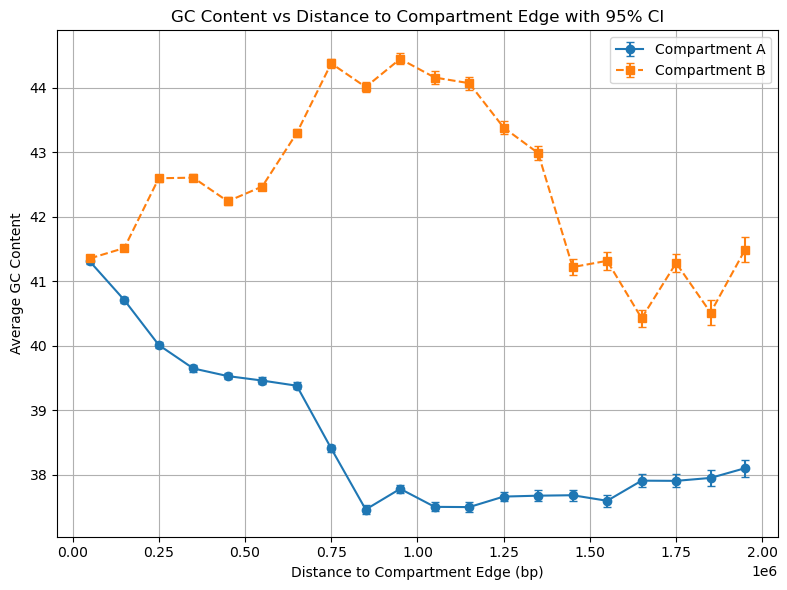

In [9]:
def plot_gc_by_compartment_with_error(A_df, B_df, num_bins=20, max_dist=2_000_000):
    bins = np.linspace(0, max_dist, num_bins + 1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    def compute_bin_stats(df):
        means = []
        sems = []

        for i in range(len(bins) - 1):
            bin_data = df[(df['absmid'] >= bins[i]) & (df['absmid'] < bins[i + 1])]
            gc_values = bin_data['value'].dropna()

            if len(gc_values) > 0:
                means.append(gc_values.mean())
                sems.append(gc_values.std(ddof=1) / np.sqrt(len(gc_values)))
            else:
                means.append(np.nan)
                sems.append(np.nan)

        means = np.array(means)
        sems = np.array(sems)
        ci_95 = 1.96 * sems  # <- Apply 95% confidence interval here
        return means, ci_95

    # Compute 95% CI for both compartments
    A_means, A_ci = compute_bin_stats(A_df)
    B_means, B_ci = compute_bin_stats(B_df)

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.errorbar(bin_centers, A_means, yerr=A_ci, label="Compartment A",
                 marker='o', linestyle='-', capsize=3)
    plt.errorbar(bin_centers, B_means, yerr=B_ci, label="Compartment B",
                 marker='s', linestyle='--', capsize=3)

    plt.xlabel("Distance to Compartment Edge (bp)")
    plt.ylabel("Average GC Content")
    plt.title("GC Content vs Distance to Compartment Edge with 95% CI")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_gc_by_compartment_with_error(fibroblast_A, fibroblast_B)


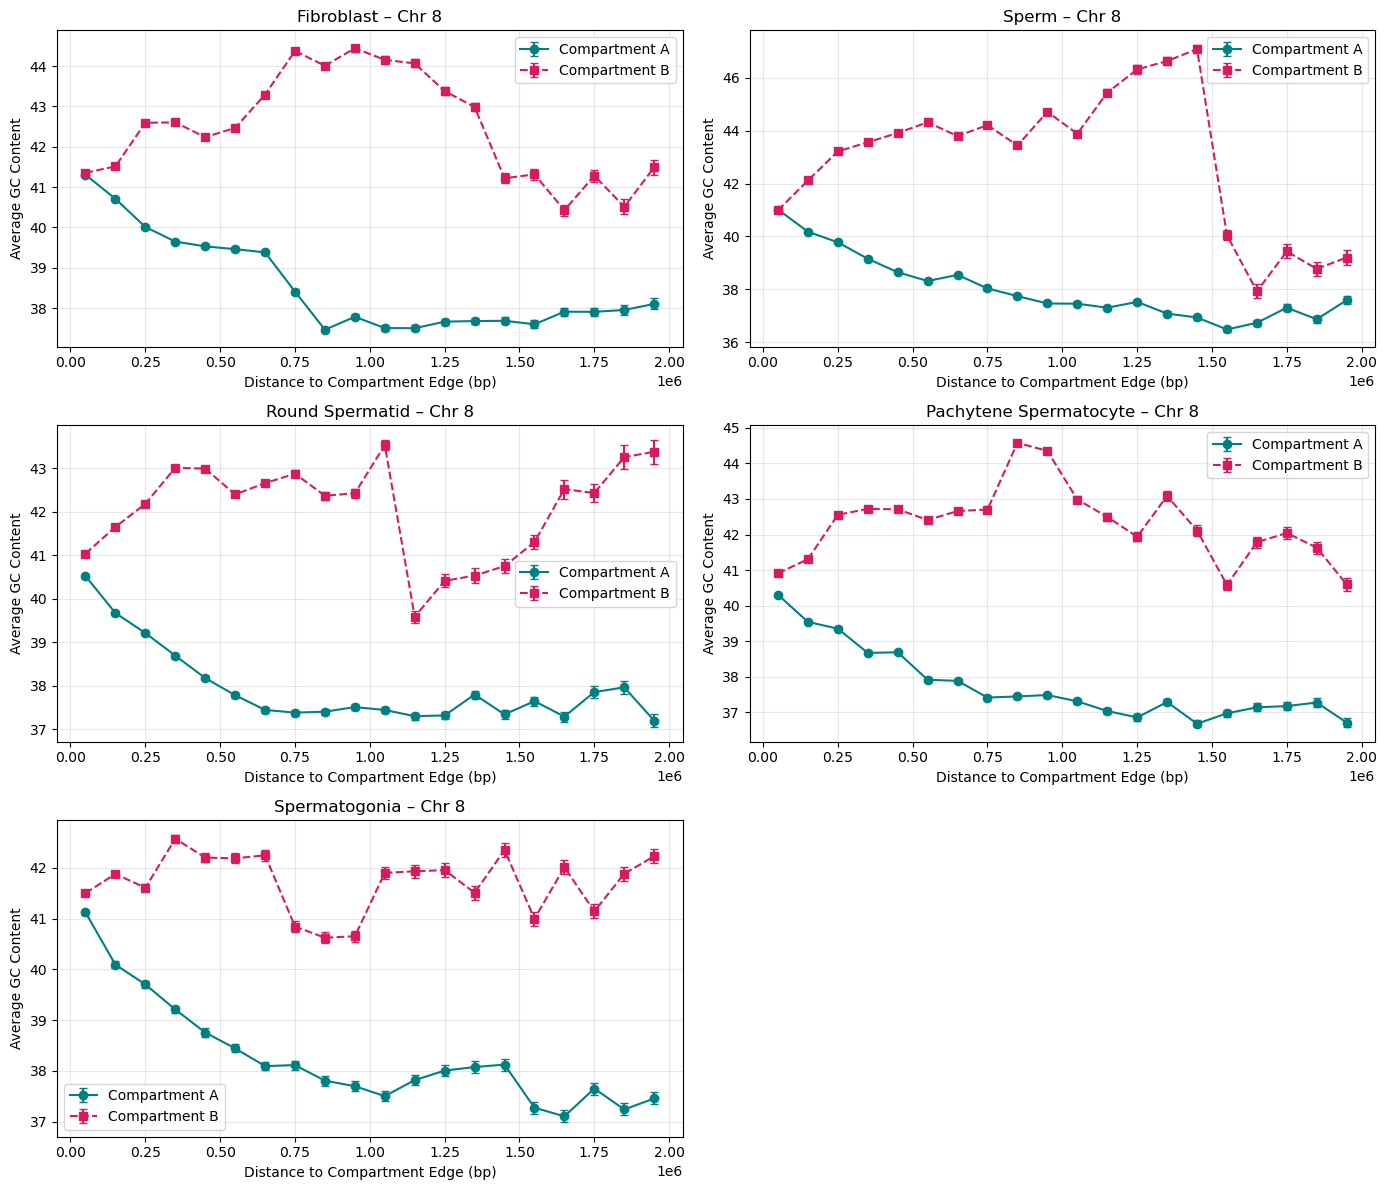

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def plot_gc_by_compartment_with_error(ax, df, title, num_bins=20, max_dist=2_000_000):
    # keep only rows within the distance window
    df = df[df['absmid'] <= max_dist].copy()

    bins = np.linspace(0, max_dist, num_bins + 1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # New non-blue/orange colors
    A_color = "#008080"  # deep teal
    B_color = "#D81B60"  # warm magenta

    def compute_bin_stats(df_slice):
        means, sems = [], []
        for i in range(len(bins) - 1):
            lo, hi = bins[i], bins[i + 1]
            gc_values = df_slice.loc[(df_slice['absmid'] >= lo) & (df_slice['absmid'] < hi), 'value'].dropna()
            if len(gc_values) > 1:
                sem = gc_values.std(ddof=1) / np.sqrt(len(gc_values))  # SEM
                means.append(gc_values.mean())
                sems.append(1.96 * sem)  # 95% CI
            elif len(gc_values) == 1:
                means.append(gc_values.iloc[0])
                sems.append(np.nan)  # not enough data for CI
            else:
                means.append(np.nan)
                sems.append(np.nan)
        return np.array(means), np.array(sems)

    # Define "A side" vs "B side"
    A_side = df[((df['comp'] == 'A') & (df['start'] > 0)) |  # right of origin if A
                ((df['comp'] == 'B') & (df['start'] < 0))]  # left of origin if B

    B_side = df[((df['comp'] == 'A') & (df['start'] < 0)) |  # left of origin if A
                ((df['comp'] == 'B') & (df['start'] > 0))]  # right of origin if B

    A_means, A_err = compute_bin_stats(A_side)
    B_means, B_err = compute_bin_stats(B_side)

    ax.errorbar(bin_centers, A_means, yerr=A_err, label="Compartment A", 
                marker='o', linestyle='-', capsize=3, color=A_color)
    ax.errorbar(bin_centers, B_means, yerr=B_err, label="Compartment B", 
                marker='s', linestyle='--', capsize=3, color=B_color)

    ax.set_title(f"{title} – Chr 8")  # clearly states Chr 8
    ax.set_xlabel("Distance to Compartment Edge (bp)")
    ax.set_ylabel("Average GC Content")
    ax.grid(True, alpha=0.3)
    ax.legend()

# --- usage ---
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.flatten()

datasets = [
    ("Fibroblast", fibroblast),
    ("Sperm", sperm),
    ("Round Spermatid", round_spermatid),
    ("Pachytene Spermatocyte", pachytene_spermatocyte),
    ("Spermatogonia", spermatogonia),
]

for i, (label, df) in enumerate(datasets):
    plot_gc_by_compartment_with_error(axes[i], df, title=label)

for j in range(len(datasets), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


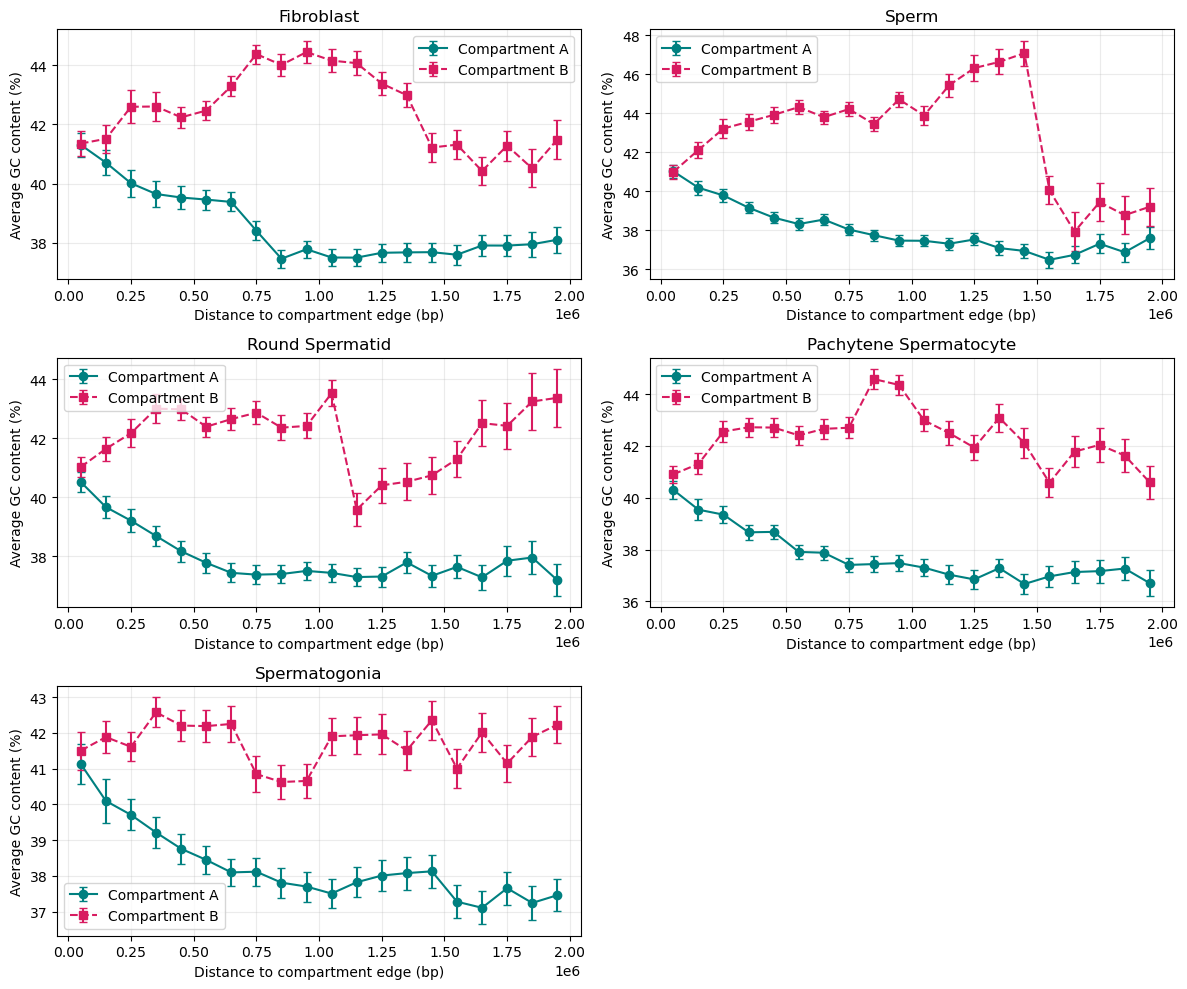

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# --- helpers ---------------------------------------------------------------
A_color = "#008080"  # deep teal
B_color = "#D81B60"  # warm magenta

def _bin_edges(max_dist=2_000_000, bins=20):
    edges = np.linspace(0, max_dist, bins + 1)
    centers = 0.5 * (edges[:-1] + edges[1:])
    return edges, centers

def _edge_availability(edge_df, max_dist=2_000_000, bins=20):
    """Return cumulative fraction of available edges per bin for comp A and B."""
    edges, _ = _bin_edges(max_dist, bins)
    out = {}
    for comp in ("A", "B"):
        starts = edge_df.loc[edge_df["comp"] == comp, "start"].values
        if starts.size < 2:
            counts = np.zeros(bins, dtype=int)
        else:
            half_d = (starts[1:] - starts[:-1]) / 2.0
            counts, _ = np.histogram(half_d, bins=edges)
        cum = counts.cumsum()
        frac = cum / cum.sum() if cum.sum() else np.zeros_like(cum, dtype=float)
        out[comp] = frac
    return out  # {"A": frac, "B": frac}

def _comp_sides(df):
    """Split into A-side and B-side using your sign logic (no changes)."""
    A_side = df[((df['comp'] == 'A') & (df['start'] > 0)) |
                ((df['comp'] == 'B') & (df['start'] < 0))]
    B_side = df[((df['comp'] == 'A') & (df['start'] < 0)) |
                ((df['comp'] == 'B') & (df['start'] > 0))]
    return A_side, B_side

def _bin_stats(gc_df, edges, edge_frac):
    """Mean and 95% CI using SEM, scaled by edge availability as effective N."""
    means = []
    errs  = []
    counts= []
    for lo, hi, f in zip(edges[:-1], edges[1:], edge_frac):
        sel = gc_df[(gc_df["absmid"] >= lo) & (gc_df["absmid"] < hi)]["value"].dropna().to_numpy()
        n = sel.size
        counts.append(n)
        if n == 0:
            means.append(np.nan); errs.append(np.nan); continue
        m = float(sel.mean())
        if n == 1:
            # single-point guardrail: plot point, small default error
            e = 0.05
        else:
            # effective N down-weights sparse edge availability
            eff_n = max(n * max(f, 0.01), 1.0)
            sd = sel.std(ddof=1)
            sem = sd / np.sqrt(eff_n)
            e = 1.96 * sem  # approx 95% CI
        means.append(m); errs.append(e)
    return np.array(means), np.array(errs), np.array(counts)

# --- plotting --------------------------------------------------------------

def plot_gc_by_compartment_simple(ax, df, edge_df, title,
                                  max_dist=2_000_000, bins=20):
    """One clean plot: A/B means with edge-weighted 95% CI error bars."""
    # prep
    df = df.loc[df["absmid"] <= max_dist].copy()
    edges, centers = _bin_edges(max_dist, bins)
    avail = _edge_availability(edge_df, max_dist, bins)
    A_side, B_side = _comp_sides(df)

    # stats
    A_m, A_e, A_n = _bin_stats(A_side, edges, avail["A"])
    B_m, B_e, B_n = _bin_stats(B_side, edges, avail["B"])

    # draw (minimal styling)
    ax.errorbar(centers, A_m, yerr=A_e, marker='o', linestyle='-',
                label='Compartment A', capsize=3, color =A_color)
    ax.errorbar(centers, B_m, yerr=B_e, marker='s', linestyle='--',
                label='Compartment B', capsize=3, color =B_color)

    ax.set_title(title)
    ax.set_xlabel("Distance to compartment edge (bp)")
    ax.set_ylabel("Average GC content (%)")
    ax.grid(True, alpha=0.25)
    ax.legend(loc="best")

    return ax

def plot_many_datasets_simple(datasets, edge_datasets,
                              max_dist=2_000_000, bins=20, ncols=2, figsize=(12, 10)):
    """
    datasets: list of (title, df)
    edge_datasets: list of edge_df (same order)
    """
    n = len(datasets)
    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = np.atleast_1d(axes).ravel()

    for i, ((title, df), edge_df) in enumerate(zip(datasets, edge_datasets)):
        plot_gc_by_compartment_simple(axes[i], df, edge_df, title,
                                      max_dist=max_dist, bins=bins)
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    fig.tight_layout()
    return fig


fig = plot_many_datasets_simple(
    datasets=[
        ("Fibroblast", fibroblast),
        ("Sperm", sperm),
        ("Round Spermatid", round_spermatid),
        ("Pachytene Spermatocyte", pachytene_spermatocyte),
        ("Spermatogonia", spermatogonia),
    ],
    edge_datasets=[
        fibroblast_e1_100kb_edges_AB,
        sperm_e1_100kb_edges_AB,
        round_spermatid_e1_100kb_edges_AB,
        pachytene_spermatocyte_e1_100kb_edges_AB,
        spermatogonia_e1_100kb_edges_AB,
    ],
    bins=20,
    max_dist=2_000_000,
)
plt.show()


## How the Error Bar is Calculated

The error bar is a **95% confidence interval** calculated from the **standard error of the mean (SEM)**, adjusted for **edge availability**.

---

### 1. Collect GC values for the bin
We take all `value` entries whose `absmid` distance is between `lo` and `hi`.

Example:  
gc values in bin: [0.41, 0.43, 0.39, 0.40]  
n = 4

---

### 2. Get edge availability fraction
From `_edge_availability()`, we determine the fraction of edges that exist up to that bin.

Example:  
edge_fraction = 0.5  # 50% of possible edges are available

---

### 3. Compute the effective sample size
We **down-weight** the sample size by edge availability:

effective_N = n * max(edge_fraction, 0.01)

Example:  
effective_N = 4 * 0.5 = 2

If `edge_fraction` is very small, it is floored at `0.01` to avoid division by zero.

---

### 4. Compute the SEM
The **standard error of the mean** is:

SEM = sample_standard_deviation / sqrt(effective_N)

Example:  
Sample std dev (ddof=1): std = 0.01732  
SEM = 0.01732 / sqrt(2) ≈ 0.01224

---

### 5. Convert SEM to 95% CI
Multiply the SEM by `1.96` (approximate z-score for 95% confidence):

error = 1.96 * SEM

Example:  
error ≈ 1.96 * 0.01224 ≈ 0.02397

This is the **y-error bar length** for that bin.

---

### 6. Special cases
- n = 1 → no variation to compute → set error to a small fixed value (e.g., 0.05)
- n = 0 → no data → error = NaN

---

### Final formula
Error = 1.96 * (std_dev / sqrt(n * max(edge_fraction, 0.01)))


check what A and B means in comp
change error bars so when we redo data into bins we calculate error from that bin???
change color depending on data 


in cpg islands chenk conut of edges (kanter)


recombination or ctcf 
find et bedre navn til repository

just for a updata